## Setting

### Optional

In [20]:
!pip install xgboost lightgbm catboost -U

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
root = "/content/drive/MyDrive/3-2 기계학습/team project/"
import sys
sys.path.append(root)

### Required

In [23]:
from open.train_tuning import Model
from open.evaluation import show_confusion_matrix, show_roc_curve, show_pr_curve, show_prediction_score

is_binary = True

In [24]:
model_type = "logit"
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
selected_features = ['mean_iat', 'std_iat', 'median_iat', 'q25_iat', 'q75_iat', 'ratio_out',
       'switch_count', 'duration', 'n_packets', 'burst_count', 'burst_mean',
       'burst_std', 'burst_max', 'burst_ratio_in', 'num_in', 'num_out',
       'frac_in', 'in_first30', 'out_first30', 'mean_iat_first30',
       'std_iat_first30', 'median_iat_first30', 'q25_iat_first30',
       'q75_iat_first30', 'ratio_out_first30', 'switch_count_first30',
       'duration_first30', 'burst_count_first30', 'burst_mean_first30',
       'burst_std_first30', 'burst_max_first30', 'burst_ratio_in_first30',
       'frac_in_first30'] # fixed

## Loading Data

In [25]:
import pickle
import pandas as pd
import numpy as np

use_original_data = False

# Load the pickle file
print("Loading datafile...")
with open(f"{root}data/preprocess_data_33/open_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y_binary"]
    y_train = np.where(y_train == -1, 0, y_train)

with open(f"{root}data/preprocess_data_33/open_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y_binary"]
    y_val = np.where(y_val == -1, 0, y_val)

if use_original_data:
  X_train = train['scaler'].inverse_transform(train['X'])
  X_train = pd.DataFrame(X_train)
  X_train.columns = train['feature_names']

  X_val = val['scaler'].inverse_transform(val['X'])
  X_val = pd.DataFrame(X_val)
  X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 20300
Validation data size:	 4350


In [26]:
# feature selection
def feature_selection(X, selected_features):
  return X[selected_features]

X_train = feature_selection(X_train, selected_features)
X_val = feature_selection(X_val, selected_features)

## Model

### Base Model Training

In [27]:
model = Model(is_binary=is_binary)
# change the model type and parameters accordingly
model.create_model(model_type, n_estimators = 2)
print(model.hparams)
model.fit(X_train, y_train)

{'penalty': 'l2', 'C': 1.0}


In [28]:
y_test_pred = model.predict(X_val)
y_test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [29]:
model.score(X_val, y_val)

0.8324137931034483

In [30]:
_ = model.k_fold_cv(X_train, y_train, k = 5)

5-fold Cross Validation Scores:	[0.82093596 0.82463054 0.82832512 0.82413793 0.83472906]
5-fold Cross Validation Average Score:	0.826551724137931


### Feature Evaluation

In [31]:
model.get_feature_importances()

{'burst_std_first30': -7.958299735560859,
 'burst_max_first30': 3.632942061746162,
 'burst_mean_first30': 2.7512807871837963,
 'burst_mean': 1.168110103926612,
 'std_iat_first30': 1.0492133191810733,
 'num_out': 0.9847421716630086,
 'duration_first30': -0.8455718073492259,
 'mean_iat_first30': -0.8455718073492061,
 'burst_std': -0.689605559224081,
 'std_iat': -0.6070724502208321,
 'duration': 0.604955848127479,
 'mean_iat': 0.5716123188753198,
 'switch_count_first30': -0.561463814811771,
 'burst_count_first30': -0.561463814811771,
 'switch_count': -0.5429417136536415,
 'burst_count': -0.5429417136536415,
 'ratio_out_first30': -0.3674594171480449,
 'in_first30': 0.36745941714783764,
 'out_first30': -0.36745941714783764,
 'frac_in_first30': 0.3674594171470146,
 'burst_max': -0.31175252402186326,
 'burst_ratio_in_first30': -0.23897990272556655,
 'num_in': -0.13552079308338524,
 'q75_iat': -0.12358922374233826,
 'q75_iat_first30': 0.08920533070588486,
 'frac_in': 0.05590673374826462,
 'rat

### Hyperparameter Tuning

In [32]:
# define parameter search space
bst = model.grid_search(X_train, y_train, param_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.774 total time=   0.3s
[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.770 total time=   0.2s
[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.776 total time=   0.2s
[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.772 total time=   0.2s
[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.768 total time=   0.3s
[CV 1/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=0.01, penalty=l

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

Model type:	Logistic Regression Model
Best score:	0.826551724137931
Best parameters:	{'C': 1, 'penalty': 'l2'}
Best estimator:	LogisticRegression(C=1)


### Evaluation

In [33]:
y = y_val
y_pred = bst.predict(X_val)
y_prob = bst.predict_proba(X_val)[:, 1]

1. Confusion Matrix

              precision    recall  f1-score   support

 unmonitored       0.77      0.74      0.75      1500
   monitored       0.86      0.88      0.87      2850

    accuracy                           0.83      4350
   macro avg       0.82      0.81      0.81      4350
weighted avg       0.83      0.83      0.83      4350



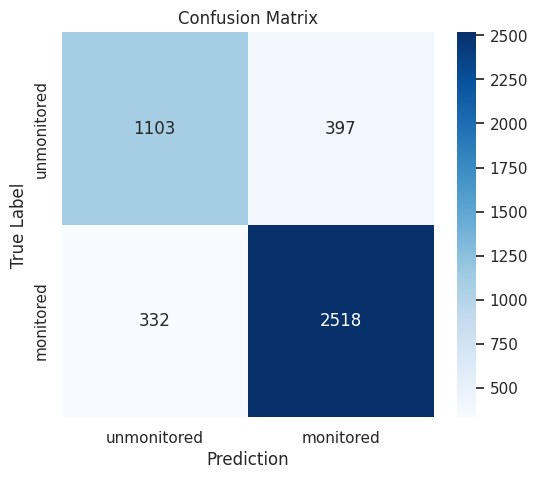

In [34]:
show_confusion_matrix(y, y_pred, model_type)

2. ROC Curve

- ROC AUC Score: 0.8993


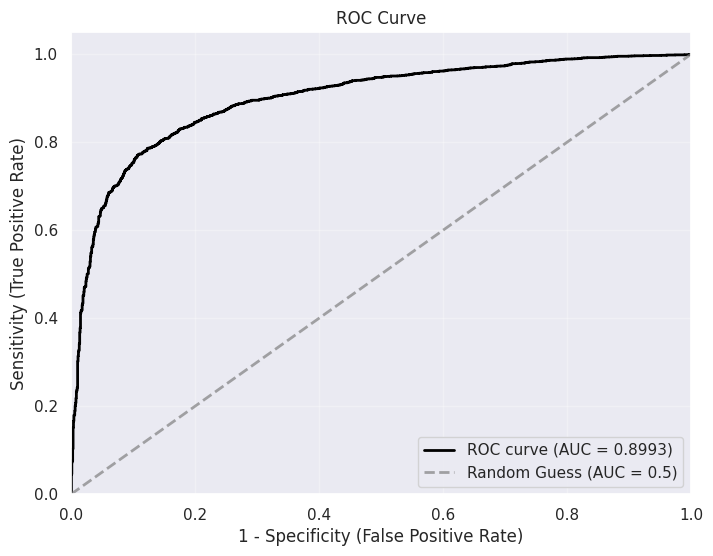

In [35]:
show_roc_curve(y, y_prob, model_type)

3. PR Curve

- Average Precision (AP) Score: 0.9419


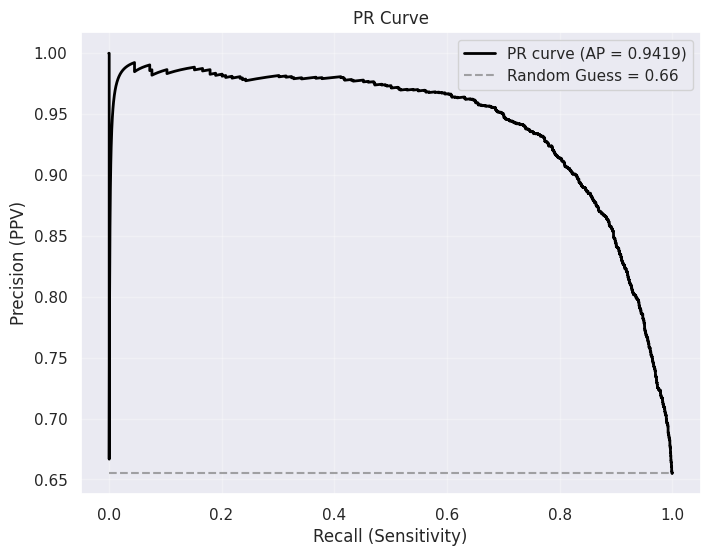

In [36]:
show_pr_curve(y, y_prob, model_type)

4. Prediction Score


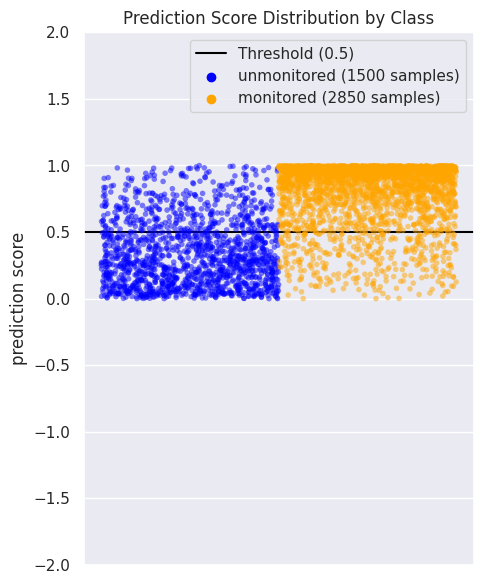

In [37]:
show_prediction_score(y, y_prob, model_type)

### Save Model

In [38]:
model.save_model(model=bst.best_estimator_, file_name=f"{bst.best_params_}")